In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

#### Ali Shobeiri - 260665549

### Question answers for each section are found at the end of the section

In [2]:
# code adapted from openCV2 python tutorial
def plot_figures(imgs, titles=None, max_col=4):
    n = len(imgs)
    rows_per = 8 // max_col 
    fig_per = rows_per * max_col
    figs_row = math.ceil(n / fig_per)
    
    for s in range(figs_row):
        # starting index of your set
        start = s * fig_per
        
        # compute the number of images and rows in the current set 
        subset_len = min(start + fig_per, n) - start
        nb_rows = math.ceil(subset_len / max_col)
         
        subplot = "{}{}".format(nb_rows, max_col)
        plt.figure(figsize=(20, 4 * nb_rows))
        for i in range(subset_len):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            if titles is not None: 
                plt.title(titles[start + i])
            else:
                plt.title(str(start + i + 1))
            plt.axis('off')
            plt.imshow(imgs[start + i].astype(np.uint8), cmap='gray')
    plt.show()

### 1. Load all images: 

In [3]:
folder_dir = "./Photos/Cropped"
image_list = []
labels = []
for file in os.listdir(folder_dir):
    img_path = folder_dir + "/" + file
    images = np.array(os.listdir(img_path))
    for i in images:
        i_path = img_path + "/" + i
        img = cv2.resize(cv2.imread(i_path, cv2.IMREAD_GRAYSCALE), (400, 500))
        image_list.append(img)
        labels.append(file)
image_list = np.array(image_list)
labels = np.array(labels)

#### Group Image:

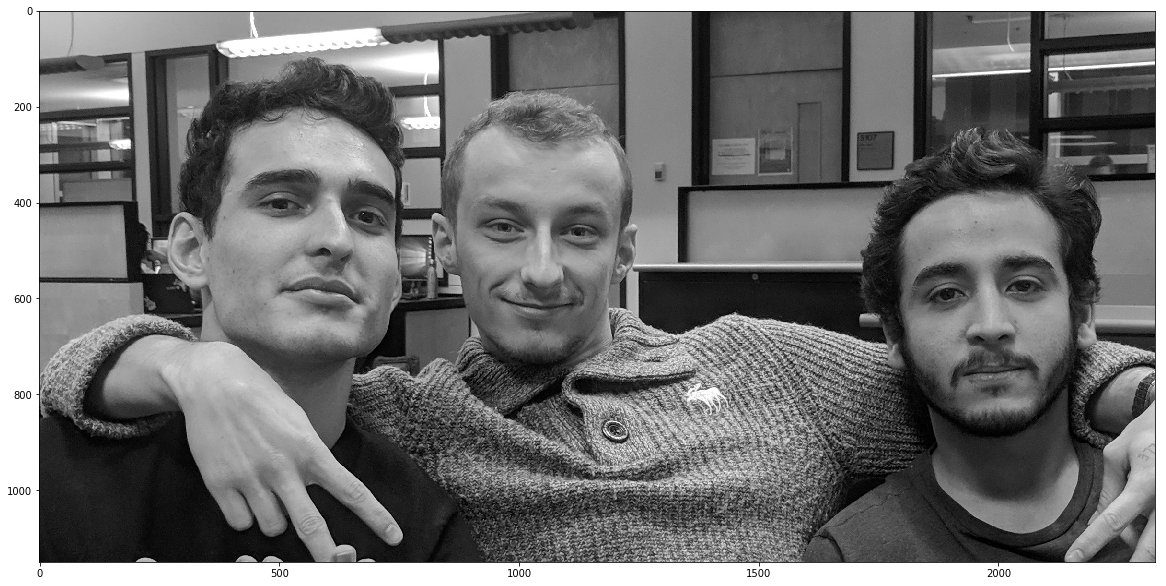

In [4]:
group = cv2.imread("./Photos/Group/Group03.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(20, 20))
plt.imshow(group, cmap="gray")
plt.show()

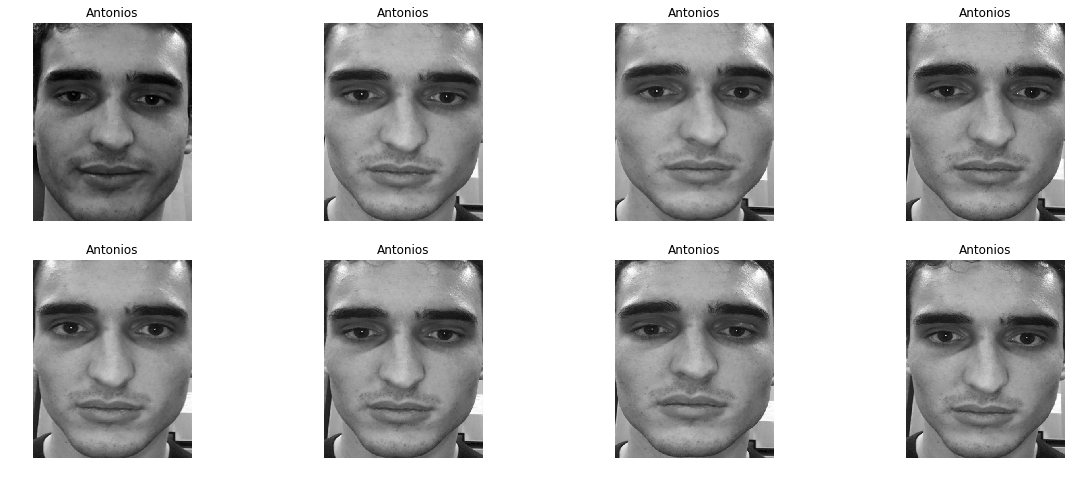

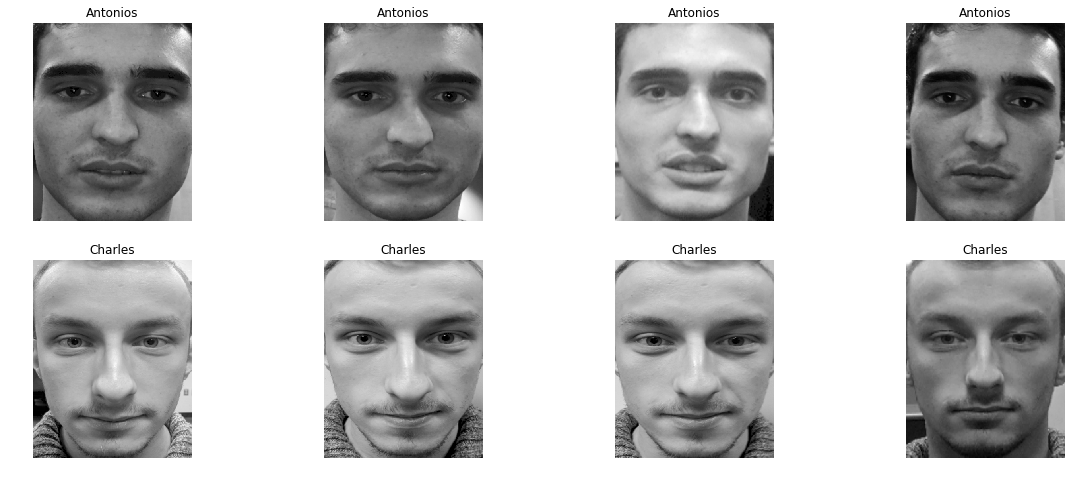

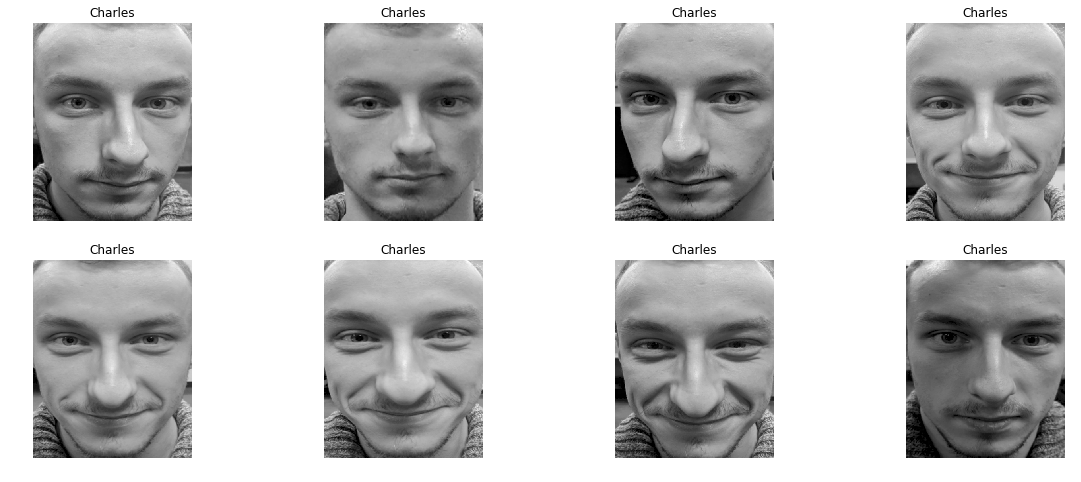

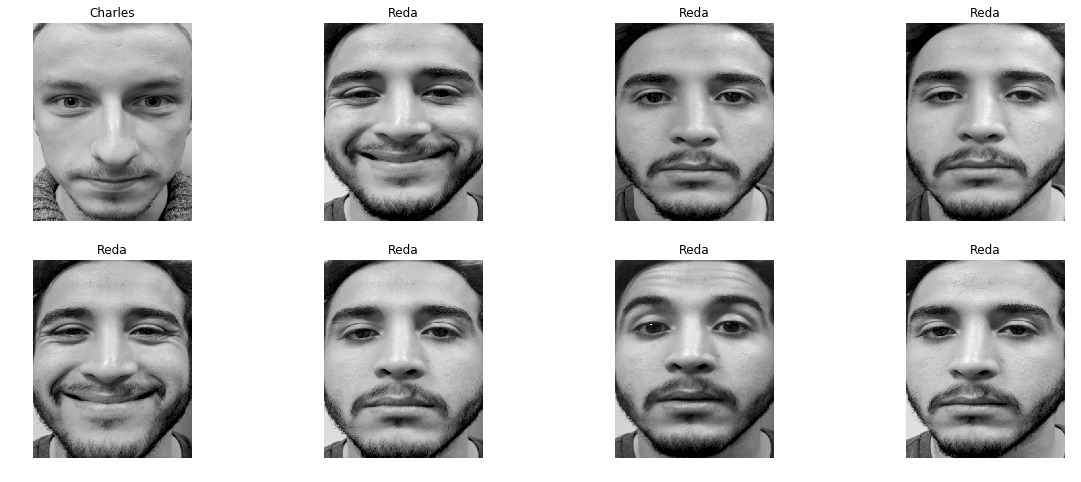

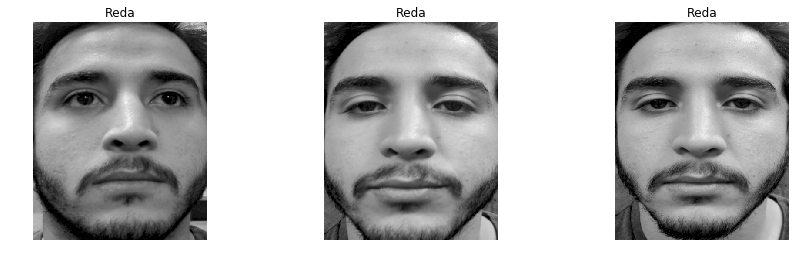

In [5]:
plot_figures(image_list, labels)

In [6]:
x_train = image_list
y_train = labels

#### Describe how you selected the images with respect to the conditions of the detection/classifcation methods

I selected the images to be all facing forward, and cropped each to be just the face of the individual, disregarding ears or hair on the individual. This was done as I knew that since we are looking to calculate eigenvectors of our data, we need them to be uniform in some manner, meaning that they are all facing the same direction and do not vary much in facial expression. I also tried to take photos under similar lighting conditions.

Greyscale images are chosen to reduce the dimensionality of the data and also to normalize the data to the same lighting conditions, meaning if the photo was taken in a brighter environment it would not affect our classification as much. 

We chose the images to be 500x400 as we are looking to make a tradeoff between accuracy and also computation time. We also can see by examining our training data that making the images this size seems to maintain their aspect ratio well. 

### 2. Calculate Eigenvectors

In [7]:
from sklearn.decomposition import PCA

In [8]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)

In [9]:
pca = PCA(n_components = 100)
x_train_pca = pca.fit_transform(x_train_flat)
var = pca.explained_variance_ratio_
var_sum = [sum(var[:i]) for i in range(len(var))]

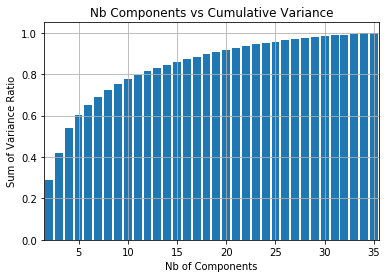

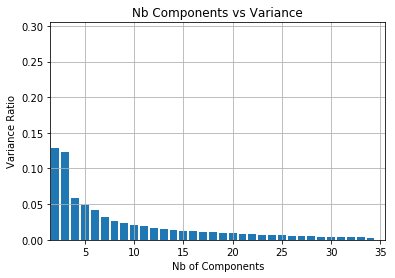

In [10]:
plt.grid(True)
plt.bar(list(range(1, len(var_sum) + 1)), var_sum)
plt.xlim(left=1.5, right=len(var_sum) + 0.5)
plt.title("Nb Components vs Cumulative Variance")
plt.ylabel("Sum of Variance Ratio")
plt.xlabel("Nb of Components")
plt.show()

plt.grid(True)
plt.bar(list(range(1, len(var) + 1)), var)
plt.xlim(left=1.5, right=len(var) + 0.5)
plt.title("Nb Components vs Variance")
plt.ylabel("Variance Ratio")
plt.xlabel("Nb of Components")
plt.show()

In [11]:
pca = PCA(n_components = 15)
x_train_pca = pca.fit_transform(x_train_flat)
print(pca.explained_variance_ratio_)

[0.29043058 0.12858529 0.12253329 0.05909849 0.04921646 0.04161354
 0.03256536 0.02706283 0.02332264 0.02058888 0.01891873 0.01620976
 0.01554235 0.01412792 0.01266611]


We will select 15 components to capture 80% of the variance and reduce our dimensionality by half.

In [12]:
nb_comp = 15
pca = PCA(n_components = nb_comp)
x_train_pca = pca.fit_transform(x_train_flat)

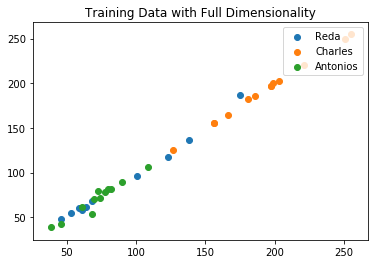

In [13]:
cls = set(np.asarray(labels))
for lab in cls: 
    x_lab = x_train_flat[y_train == lab]
    plt.scatter(x_lab[:,0], x_lab[:,1], label = lab)
    plt.legend(loc='upper right')
    plt.title("Training Data with Full Dimensionality")
plt.show()

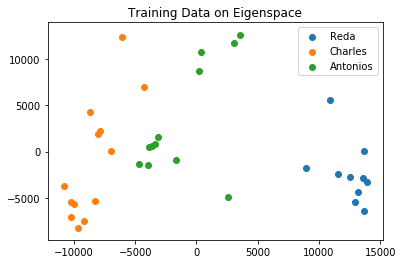

In [14]:
cls = set(np.asarray(labels))
for c in cls: 
    x_cls = x_train_pca[y_train == c]
    plt.scatter(x_cls[:,0], x_cls[:,1], label = c)
    plt.legend(loc='upper right')
    plt.title("Training Data on Eigenspace")
plt.show()

In [15]:
from sklearn.neighbors import NearestNeighbors as NN

In [16]:
nn = NN(n_neighbors = 1, metric="l2")
nn.fit(x_train_pca, labels)
val = []
for i, x in enumerate(x_train_pca):
    dist, ind = nn.kneighbors(np.reshape(x, (1, -1)), n_neighbors=2)
    val.append(y_train[i] == y_train[ind[0][1]])
print("Fraction of PCA train data with neighbor of same class: ", sum(val)/len(val))

Fraction of PCA train data with neighbor of same class:  1.0


In [17]:
nn = NN(n_neighbors = 1, metric="l2")
nn.fit(x_train_flat, labels)
val = []
for i, x in enumerate(x_train_flat):
    dist, ind = nn.kneighbors(np.reshape(x, (1, -1)), n_neighbors=2)
    val.append(y_train[i] == y_train[ind[0][1]])
    

print("Fraction of train data with neighbor of same class: ", sum(val)/len(val))

Fraction of train data with neighbor of same class:  1.0


In [18]:
eigenfaces = pca.components_.reshape((nb_comp, 500, 400))

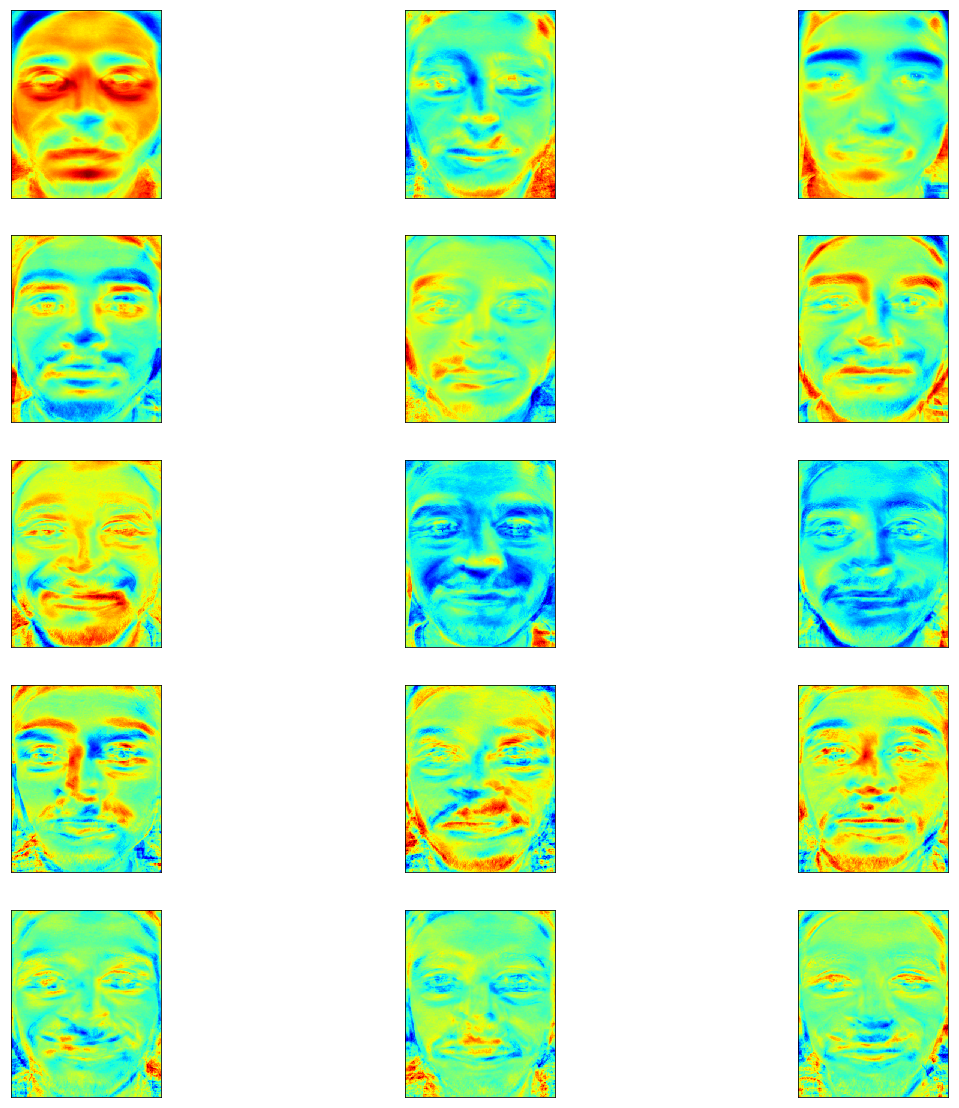

In [19]:
cols = 3
row = math.ceil(len(eigenfaces)/float(cols)) 
plt.figure(figsize=(20, 4 * row))
for i, img in enumerate(eigenfaces):
    plt.subplot(row, cols,1+i)
    plt.imshow(img, cmap='jet')
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [20]:
eigenfaces_flat = eigenfaces.reshape(eigenfaces.shape[0], -1)

### 2: Questions

#### What fraction of your data has a neighbor of the same class?

From above we can see almost our entire dataset has a nearest neighbor belonging to the same class. This is true for our PCA components as well as with our full feature set. 


####  Would you expect significant difference between feature space and PCA?
No, we would expect potentially a small difference between our PCA components and our full feature set. This is assuming we are taking enough components to account for the majority of the variance. In this case, there would not be a significant difference in the data and thus allow us much smaller difference between our feature space and PCA. 

We would expect that PCA would have a smaller accuracy ratio than in our full feature set. In PCA, since we are losing dimensionality and potentially some data, this might lead to a point moving closer to another label and being misclassified, however, in our images with the number of components selected this does not occur and both our full feature set and our PCA have the same accuracy.

#### Do you need all vectors to represent the data? Discuss

Depends on the data. In our case, since the data is of faces and faces have some commonalities we do not need all the vectors to represent 80% of the data, in practice we only need 15 vectors to represent 80% of the data.

This is because by performing PCA we are in effect calculating the eigenvectors of the training set. Theoretically eigenvectors are vectors that can form any vector or in our case image in the training set through a linear combination of eigenvectors. This property allows us to represent large sections of the data with only a few vectors. 

#### Group Image:

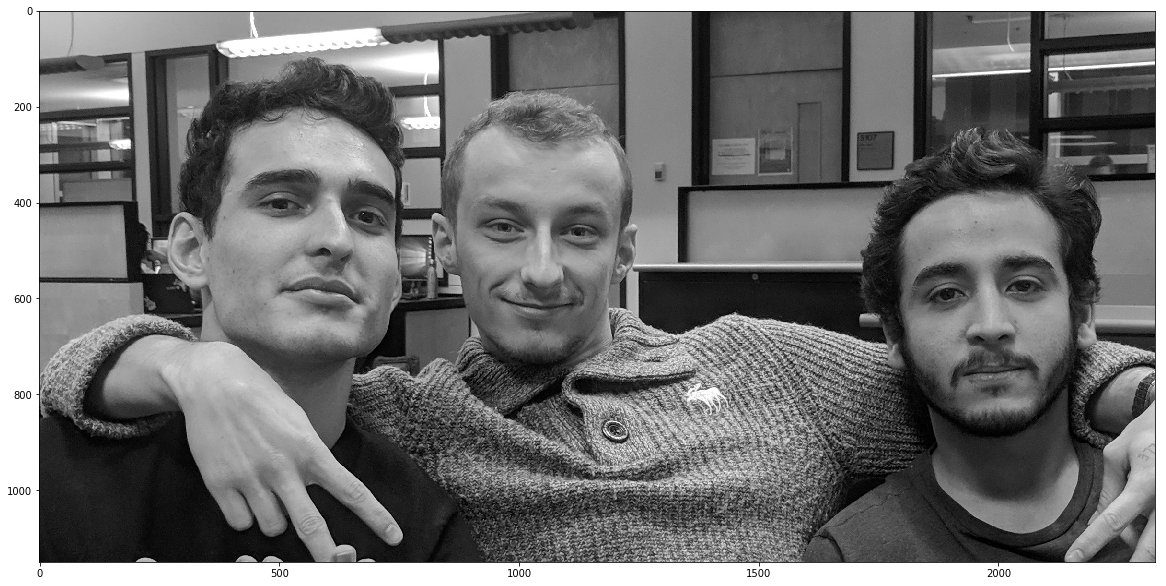

In [21]:
group = cv2.imread("./Photos/Group/Group03.jpg", cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(20, 20))
plt.imshow(group, cmap="gray")
plt.show()

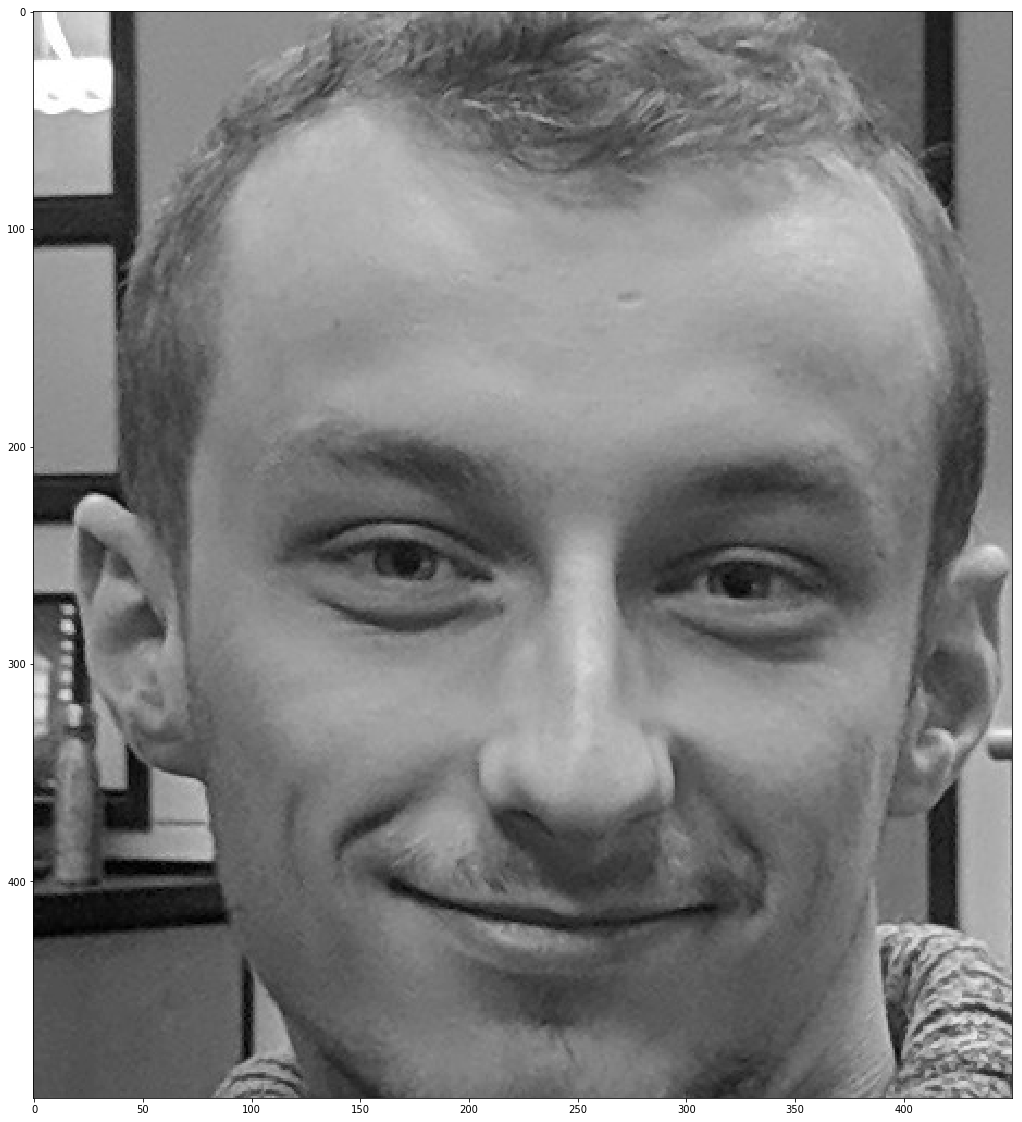

In [22]:
plt.figure(figsize=(20, 20))
plt.imshow(group[200:700,800:1250], cmap="gray")
plt.show()

We select a sliding window of 500x400 as it is most likely to include a face, we ensure that our original cropped images are of the same size to ensure maximum likelihood of detecting a face.

#### Finding mean faces:

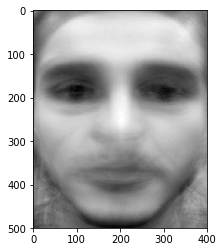

In [23]:
mean_face = pca.mean_

plt.imshow(mean_face.reshape(500, -1), cmap="gray")
plt.show()

#### Demonstration that we can reconstruct images, showing us our eigenvectors are correct:

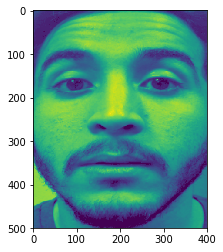

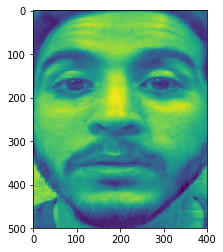

In [24]:
plt.imshow(x_train[30])
plt.show()

weights = pca.transform(x_train[30].reshape(1, -1))
const = weights[0][0] * eigenfaces[0]
for n in range(1, 15):
    const = const + weights[0][n] * eigenfaces[n]
res = const + mean_face.reshape(500, 400)
plt.imshow(res)
plt.show()

### 3. Face detection and identification:

In [25]:
def get_windows(img, stride_x = 500, stride_y = 500, box_size = (500, 400)):
    windows = []
    for i in range(0, img.shape[0] - box_size[0], stride_y):
        for j in range(0, img.shape[1] - box_size[1], stride_x):
            windows.append(img[i:i+500, j:j+400])
    return windows
            
def calc_distance(windows):
    distances = []
    windows = np.asarray(windows)
    for window in windows:
        win_flat = window.flatten()
        weights = pca.transform(win_flat.reshape(1, -1))
        
        const = 0
        for n in range(0, eigenfaces.shape[0]):
            const = const + weights[0][n] * eigenfaces[n]
        res = mean_face.reshape(500, -1) + const

        diff = window - res
        dist = np.linalg.norm(diff)
        distances.append((dist, window))
    return sorted(distances, key=lambda x:x[0])

windows = get_windows(group, 50, 50)
print("Calculating dist from window: ")
dists = calc_distance(windows)
print("Got distances")
print("Total windows: ", len(windows))

Calculating dist from window: 
Got distances
Total windows:  507


In [26]:
def detect_faces(dists):
    faces = []
    for dist in dists:
        if dist[0] > 0 and dist[0] < 20000:
            faces.append(dist)
    return faces

faces = detect_faces(dists)
print(len(faces))

19


In [27]:
dists

[(13570.395345699928, array([[136, 140, 142, ..., 134, 135, 133],
         [138, 143, 145, ..., 133, 134, 133],
         [139, 143, 146, ..., 133, 134, 134],
         ...,
         [129,  97,  90, ..., 228, 219, 213],
         [ 68,  65,  72, ..., 232, 242, 210],
         [ 70,  82, 102, ..., 232, 247, 214]], dtype=uint8)),
 (15783.62772945176, array([[165, 167, 171, ..., 101,  99,  97],
         [168, 168, 170, ..., 105, 104, 103],
         [168, 167, 169, ..., 107, 108, 108],
         ...,
         [127, 137, 152, ..., 171, 110, 109],
         [167, 170, 165, ..., 169, 130, 109],
         [176, 178, 168, ..., 153, 133, 137]], dtype=uint8)),
 (16715.6339664616, array([[124, 117, 107, ...,  44,  47,  45],
         [112,  97,  93, ...,  46,  44,  41],
         [ 98,  72,  68, ...,  48,  44,  41],
         ...,
         [ 24,  26,  33, ...,  44,  44,  41],
         [ 32,  40,  36, ...,  41,  44,  42],
         [ 38,  42,  11, ...,  42,  46,  46]], dtype=uint8)),
 (17256.056148288924, arr

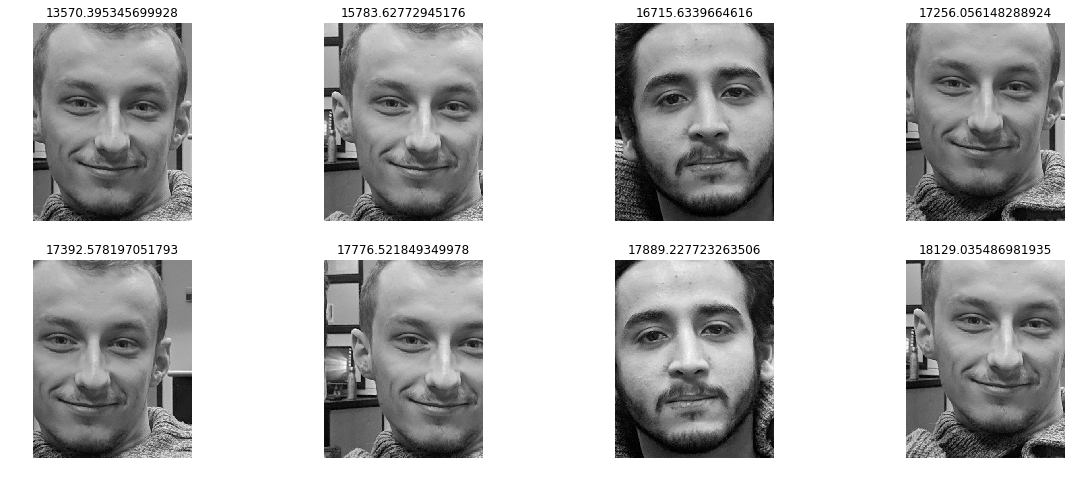

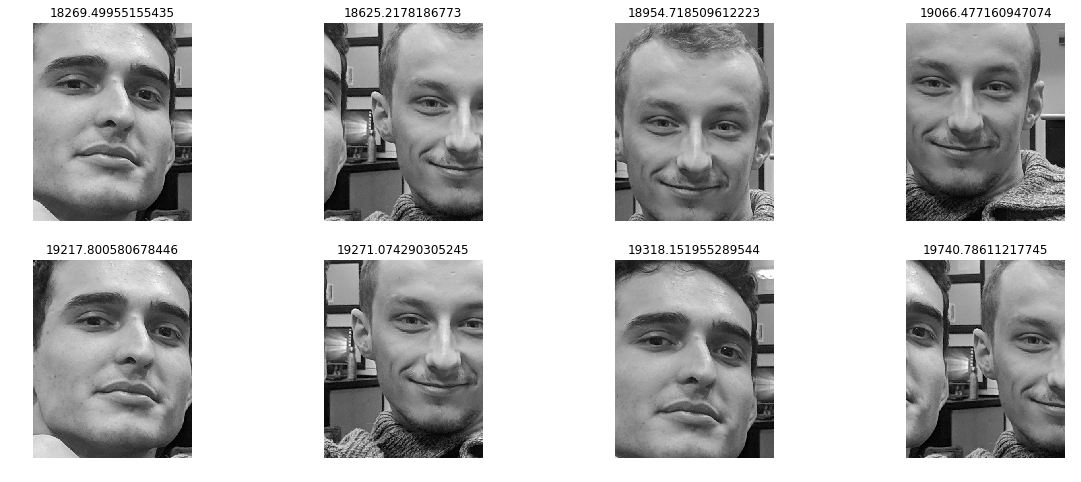

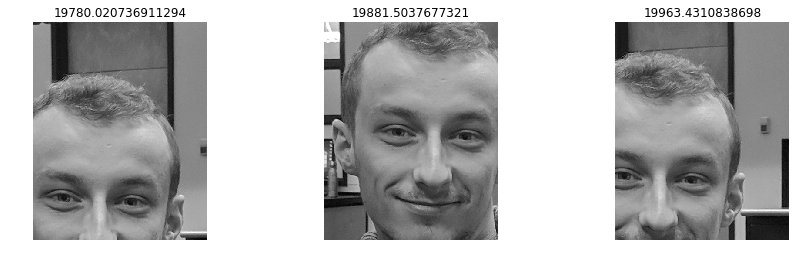

In [28]:
d_dist, d_face = zip(*faces)
d_face = np.array(list(d_face))


plot_figures(d_face.reshape(-1, 500, 400), d_dist)

In [29]:
# We hand label for desired output:
label_d_true = ["Charles", "Charles", "Reda", 
 "Charles", "Charles", "Charles", "Reda", 
 "Charles", "Antonios", "Charles", 
 "Charles", "Charles", "Antonios", 
 "Charles", "Antonios", "Charles", 
 "Charles", "Charles", "Charles"]

In [30]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [31]:
knn = KNN(n_neighbors=1)

In [32]:
knn.fit(pca.transform(x_train_flat).reshape(x_train.shape[0], -1), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [33]:
eigen_d_faces = pca.transform(d_face.reshape(d_face.shape[0], -1))

In [34]:
preds = knn.predict(eigen_d_faces)

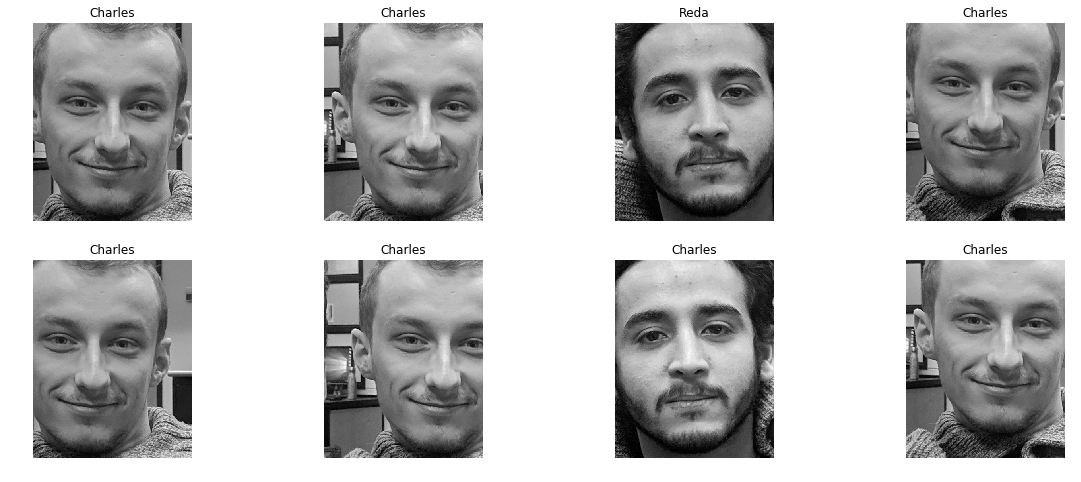

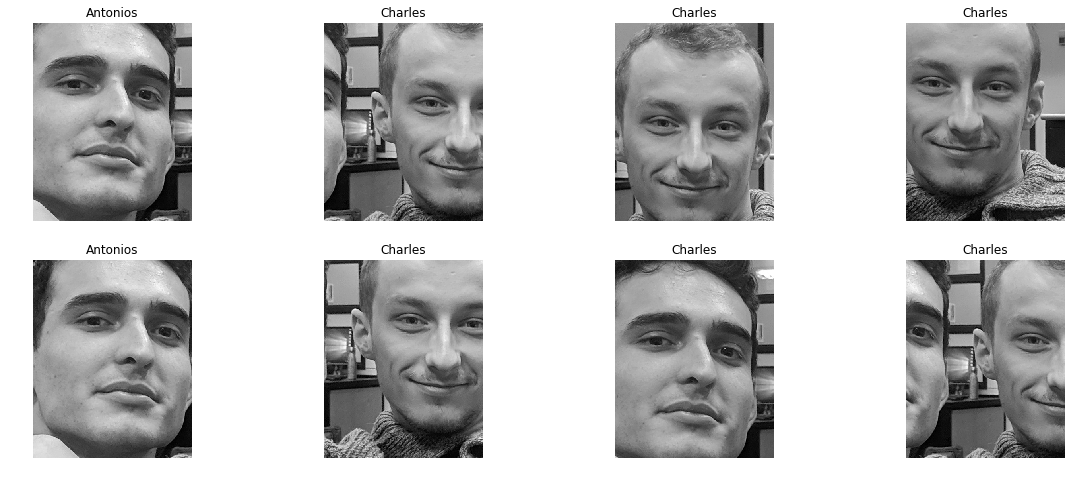

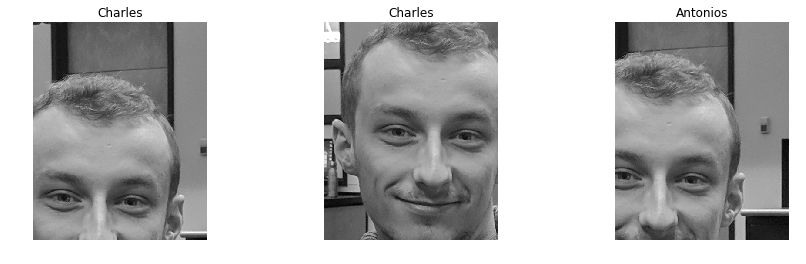

In [35]:
plot_figures(np.array(d_face).reshape(-1, 500, 400), preds)

In [36]:
import sklearn

#### Iterating through different values of K and measuring accuracy of classifier at each step:

In [37]:
for k in range(1, 10, 2):
    knn = KNN(n_neighbors=k)
    knn.fit(pca.transform(x_train_flat).reshape(x_train.shape[0], -1), y_train)
    preds = knn.predict(eigen_d_faces)
    matrix = sklearn.metrics.confusion_matrix(label_d_true, preds)
    names = ["Antonios", "Charles", "Reda"]

    print("K neighbors: ", k)
    
    print("\t \t {} \t {} \t {}".format(names[0], names[1], names[2]))
    for i, row in enumerate(matrix):
        if names[i] == "Reda":
            print("{}: \t \t {} \t \t {} \t \t {}".format(names[i], row[0], row[1], row[2]))
        else: 
            print("{}: \t {} \t \t {} \t \t {}".format(names[i], row[0], row[1], row[2]))

    print("\n")
    print("Metrics: ")
    print(sklearn.metrics.classification_report(label_d_true, preds))
    print("\n")

K neighbors:  1
	 	 Antonios 	 Charles 	 Reda
Antonios: 	 2 	 	 1 	 	 0
Charles: 	 1 	 	 13 	 	 0
Reda: 	 	 0 	 	 1 	 	 1


Metrics: 
             precision    recall  f1-score   support

   Antonios       0.67      0.67      0.67         3
    Charles       0.87      0.93      0.90        14
       Reda       1.00      0.50      0.67         2

avg / total       0.85      0.84      0.84        19



K neighbors:  3
	 	 Antonios 	 Charles 	 Reda
Antonios: 	 2 	 	 1 	 	 0
Charles: 	 1 	 	 13 	 	 0
Reda: 	 	 0 	 	 1 	 	 1


Metrics: 
             precision    recall  f1-score   support

   Antonios       0.67      0.67      0.67         3
    Charles       0.87      0.93      0.90        14
       Reda       1.00      0.50      0.67         2

avg / total       0.85      0.84      0.84        19



K neighbors:  5
	 	 Antonios 	 Charles 	 Reda
Antonios: 	 2 	 	 1 	 	 0
Charles: 	 2 	 	 12 	 	 0
Reda: 	 	 1 	 	 1 	 	 0


Metrics: 
             precision    recall  f1-score   support

   A

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


K neighbors:  9
	 	 Antonios 	 Charles 	 Reda
Antonios: 	 2 	 	 1 	 	 0
Charles: 	 2 	 	 12 	 	 0
Reda: 	 	 2 	 	 0 	 	 0


Metrics: 
             precision    recall  f1-score   support

   Antonios       0.33      0.67      0.44         3
    Charles       0.92      0.86      0.89        14
       Reda       0.00      0.00      0.00         2

avg / total       0.73      0.74      0.73        19





### 3: Questions

#### How well does KNN work with detected faces from the group photo, when they are mapped to eigenspace?

The KNN seems to work fairly well with detected faces mapped to eigenspace. We are able to achieve an F1 measure of 0.84 by comparing the detected window with its closest neighbor in the training set. This is a fairly good accuracy. 

#### How many false positive face detections do you have?

Out of about 500 different windows considered, the algorithm was able to identify 19 faces that seem to match faces very closely. Therefore, we can claim that we do not have any false positives from our face detection.

#### For misidentified faces, report the number of neighbors you need before getting the correct label?

For misidentified labels, it seems that increasing the number of neighbors does not increase the accuracy. In the misidentified images we were able to see, increasing the neighbors did not improve the labelling of the misidentified images, it began to degrade the performance of other images. 

#### In which situations would you expect this to fail? How would you improve it?
Increasing the number of neighbors would fail in the case that the number of components selected from the PCA does not accurately represent the data from the window. In this case, mapping a detected photo to the eigenspace would cause it to be clustered with data of a different class and because of this, regardless of how many more neighbors you take the points classification will not improve. To improve this and ensure that this situation does not occur we need to potentially take more components. 

### 4. Viola-Jones Comparison

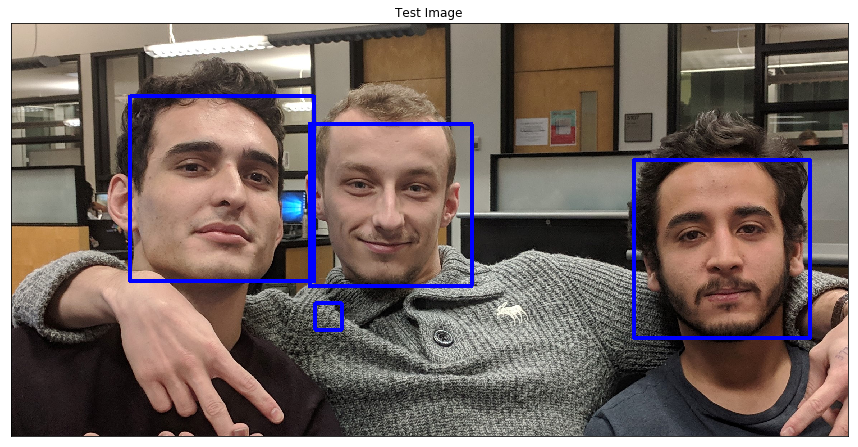

(35, 200000)


In [38]:
# from the tutorial: 
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

img = cv2.imread('./Photos/Group/Group03.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(img_gray, 1.1,2)
for (x,y,w,h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 10)



# display images
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Test Image"), plt.xticks([]), plt.yticks([])
plt.show()
knn = KNN(n_neighbors=1)
knn.fit(pca.transform(x_train_flat), y_train)
print(x_train_flat.shape)
face_list = []
for (x,y,w,h) in faces:
#     cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
    #roi_gray = img_gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    face_list.append(cv2.cvtColor(roi_color, cv2.COLOR_BGR2GRAY))
    
for i in range(len(face_list)):
    face_list[i] = cv2.resize(face_list[i], (500,400))
face_list = np.asarray(face_list)
face_list_flat = np.reshape(face_list, (face_list.shape[0], -1))
predictions = knn.predict(pca.transform(face_list_flat))

### 4: Questions

#### Under what conditions would you expect the Viola-Jones detector to work when PCA does not?

We would expect Viola-Jones to outperform in images where the faces of the individuals are turned to the side. PCA could perform in these situations but would require us to create a new dataset with images of people turned to different angles.

PCA would work for head on images, Viola-Jones would work for head on images and images that are of people with their heads turned away from the camera. 